# L'idée est d'utiliser un model déja existant pour voir ce que ça pourait donner

## Le BlaBla habituel

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Importation des modules

from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, BatchNormalization, MaxPooling2D
from keras.models import Sequential
from tensorflow import keras
from keras import activations
import tensorflow as tf
import matplotlib.image as mpimg
from skimage.measure import block_reduce
from tensorflow.keras import layers
from skimage.io import imread, imshow
import cv2 as cv
from skimage.filters import prewitt_h, prewitt_v
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime
from scipy import ndimage

In [1]:
!wget #link to dataset

wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


In [4]:
# Pour se débarasser des demandes de unzip inutiles
! mkdir data
try:
  open("./data/rien.txt", 'r')
except:
  # Faire les unzip ici
  ! unzip -q public_data.zip -d ./data
  
  f = open("./data/rien.txt" ,'w')
  f.write("rien")
  f.close()

mkdir: cannot create directory ‘data’: File exists


In [5]:
date = str(datetime.now())

## Le vif du sujet

### Traitement des données

In [6]:
def pre_traitement(image):
  """
  image est un tableau numpy directement extrait de train_df
  (sans modifications)
  """
  def rescale(channel):
    """
    Renvoie le tableau normalisé (valeurs entre 0 et 1)
    """
    a = np.max(channel)
    b = np.min(channel)
    return (channel - b )/(a-b)

  # plt.subplot(141)
  # plt.imshow(image)


  # Augmentation du contraste:  (ne modifie pas le précédent)
  alpha = 0.9 # Contrast control (1.0-3.0)
  beta = 0 # Brightness control (0-100)
  contraste = cv.convertScaleAbs(image, alpha=alpha, beta=beta)


  # Egalisation d'histogrammes:  (ne modifie pas le précédent)
  img_to_yuv_1 = cv.cvtColor (contraste, cv.COLOR_BGR2YUV)
  img_to_yuv_1 [:,:, 0] = cv.equalizeHist (img_to_yuv_1 [:,:,0])
  hist = cv.cvtColor (img_to_yuv_1, cv.COLOR_YUV2BGR) # sans agumentation du contraste


  return np.stack([rescale(channel) for channel in [contraste[:,:,0], contraste[:,:,1], contraste[:,:,2]] ], axis=-1)

In [7]:
DATA_DIR = './data/'
train_df = pd.read_csv(f'{DATA_DIR}train.csv')

Visualisation

In [8]:
train_df

,index,char,image,mask
0,0,c,train/00000.image.jpg,train/00000.mask.jpg
1,1,t,train/00001.image.jpg,train/00001.mask.jpg
2,2,w,train/00002.image.jpg,train/00002.mask.jpg
3,3,f,train/00003.image.jpg,train/00003.mask.jpg
4,4,2,train/00004.image.jpg,train/00004.mask.jpg
...,...,...,...,...
6995,6995,6,train/06995.image.jpg,train/06995.mask.jpg
6996,6996,d,train/06996.image.jpg,train/06996.mask.jpg
6997,6997,z,train/06997.image.jpg,train/06997.mask.jpg
6998,6998,i,train/06998.image.jpg,train/06998.mask.jpg


### Le model et compagnie

In [9]:
def f(x):
  return x/255

In [10]:
datagen = ImageDataGenerator(
    width_shift_range=0.15,
    height_shift_range=0.15,
    rotation_range=15,
    channel_shift_range=0.2,
    validation_split=0.2,
    preprocessing_function=pre_traitement
)

In [11]:
train_generator = datagen.flow_from_dataframe(
    train_df,
    directory=DATA_DIR,
    x_col="image",
    y_col="char",
    weight_col=None,
    target_size=(112, 112),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    interpolation="nearest",
    validate_filenames=True,
    subset="training"
)

validation_generator = datagen.flow_from_dataframe(
    train_df,
    directory=DATA_DIR,
    x_col="image",
    y_col="char",
    weight_col=None,
    target_size=(112, 112),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    interpolation="nearest",
    validate_filenames=True,
    subset="validation"
)

Found 5600 validated image filenames belonging to 36 classes.
Found 1400 validated image filenames belonging to 36 classes.


In [12]:
input_shape = (112,112,3)

In [13]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
            monitor = "val_loss",
            factor=0.3,
            patience=4,
            min_lr=1e-7,
            verbose = 1)

In [14]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="model.hdf5",
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1)

In [15]:
from keras.applications import MobileNet
from keras.models import Model
import keras

resnet = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape, classes=36, dropout=0.4)
# output = restnet.layers[-1].output
# output = keras.layers.Flatten()(output)

# restnet = Model(restnet.input, outputs=output)

# for layer in restnet.layers:
#     layer.trainable = False

resnet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 56, 56, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 56, 56, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 56, 56, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 56, 56, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 56, 56, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 56, 56, 32) 

In [16]:
!pip install tensorflow_addons

In [17]:
import tensorflow_addons.optimizers.rectified_adam

In [18]:
tensorflow_addons.optimizers.rectified_adam.RectifiedAdam

tensorflow_addons.optimizers.rectified_adam.RectifiedAdam

In [19]:
model = Sequential()
for layer in resnet.layers:
  model.add(layer)
  if layer.name in ["conv_pw_9_relu", "conv_pw_13_relu", "conv_pw_11_relu", "conv_pw_7_relu", "conv_pw_5_relu", "conv_pw_3_relu"]:
    model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, input_dim=input_shape))
model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
model.add(Dropout(0.4))
model.add(Dense(512))
model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
model.add(Dropout(0.4))
model.add(Dense(36, activation='softmax'))

from keras import optimizers
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 56, 56, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 56, 56, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 56, 56, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 56, 56, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 56, 56, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 56, 56, 32)        0         
_________________________________________________________________
conv_pw_1 (Conv2D)           (None, 56, 56, 64)        2

### *L'entrainement*

In [20]:
history = model.fit(train_generator, epochs=70, validation_data=validation_generator,
                    verbose=1,
                    callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/70
175/175 [==============================] - 43s 218ms/step - loss: 6.3429 - accuracy: 0.0399 - val_loss: 5.8836 - val_accuracy: 0.0529

Epoch 00001: val_loss improved from inf to 5.88359, saving model to model.hdf5
Epoch 2/70
175/175 [==============================] - 38s 217ms/step - loss: 3.4472 - accuracy: 0.0982 - val_loss: 3.1944 - val_accuracy: 0.1479

Epoch 00002: val_loss improved from 5.88359 to 3.19443, saving model to model.hdf5
Epoch 3/70
175/175 [==============================] - 38s 217ms/step - loss: 3.0931 - accuracy: 0.1695 - val_loss: 2.9245 - val_accuracy: 0.2243

Epoch 00003: val_loss improved from 3.19443 to 2.92450, saving model to model.hdf5
Epoch 4/70
175/175 [==============================] - 38s 218ms/step - loss: 2.7868 - accuracy: 0.2417 - val_loss: 2.1424 - val_accuracy: 0.3536

Epoch 00004: val_loss improved from 2.92450 to 2.14239, saving model to model.hdf5
Epoch 5/70
175/175 [==============================] - 38s 218ms/step - loss: 2.4211 - ac

In [21]:
model.load_weights("model.hdf5")

In [22]:
a = model.evaluate(validation_generator)
print(a)

44/44 [==============================] - 7s 150ms/step - loss: 0.8585 - accuracy: 0.7800
[0.8584847450256348, 0.7799999713897705]


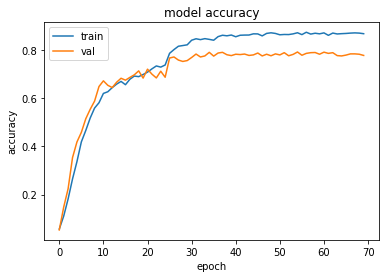

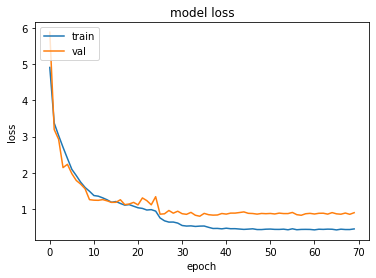

In [23]:
def plot_history(history):
    """
    plot l'accuracy et la loss
    """
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot_history(history)

In [24]:
model.save("/content/drive/MyDrive/Colab Notebooks/new_dataset/transfer_learning_v2/model" + str(a[0]) + "_" + str(a[1]))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/new_dataset/transfer_learning_v2/model0.8584847450256348_0.7799999713897705/assets
